In [44]:

from matplotlib import pyplot as plt
import random
import os
import librosa
import torch
from torch import nn
from torch.nn import Conv2d
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from pathlib import Path


import numpy as np

import random

from scipy.signal import spectrogram

SAMPLE_RATE = 16000
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 625, 469, 3
DURATION = 1
BATCH_SIZE = 32
EPOCHS = 10

#path = 'audio_files/for-2sec/for-2seconds'
path = 'audio_files_samples'

class AudioData(Dataset):
    def __init__(self, root_dir, subset, transform, sample_rate=SAMPLE_RATE):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.transform = transform
        self.subset = subset
        self.sample_rate = SAMPLE_RATE
        self.classes = {'fake': 0, 'real': 1}
        self.files = []

        
        for label in self.classes:
            class_path = os.path.join(self.root_dir, subset, label)
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                self.files.append((file_path, self.classes[label]))

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        spec = convert_to_spectrogram(file_path)
        # shit doesnt normalize yet
        # if self.transform:
        #     spec = self.transform(spec)
        return spec, label
        
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(CHANNELS, 32, kernel_size=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Dropout(0.1),
            nn.Conv2d(128, 256, kernel_size=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            
            nn.Linear(512, 2),
            nn.Softmax()
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


def convert_to_spectrogram(filepath):
    audio, _ = librosa.load(filepath, sr=SAMPLE_RATE, duration=DURATION)
    spec = librosa.stft(audio)
    return librosa.amplitude_to_db(np.abs(spec), ref=np.max)

def print_sample_spec(spec, is_numpy=False):
    # Need this or else cant plot with librosa
    if not is_numpy:
        spec = spec.numpy()
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(spec, x_axis='time', y_axis='log', cmap='viridis')
    #plt.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('STFT Spectrogram (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

def get_sample(loader, get_label=False):
    spectrograms, labels = next(iter(loader))
    index = random.randint(0, len(spectrograms) - 1)
    if get_label:
        return spectrograms[index], labels[index]
    return spectrograms[index]

def create_dataloaders(root_dir, batch_size=BATCH_SIZE):
    # How to normalize this shit?
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    train_dataset = AudioData(root_dir=root_dir, subset='training', transform=transform)
    val_dataset = AudioData(root_dir=root_dir, subset='validation', transform=transform)
    test_dataset = AudioData(root_dir=root_dir, subset='testing', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)#TODO: Change to true, when actually training
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader



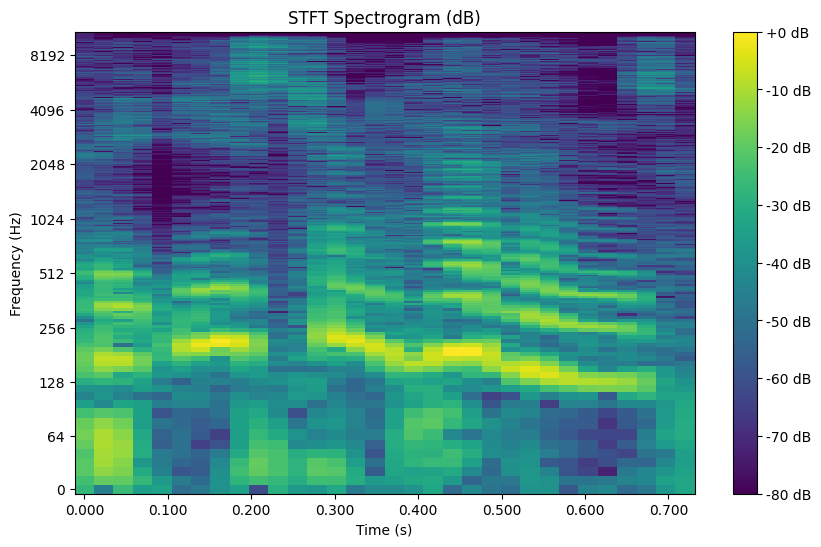

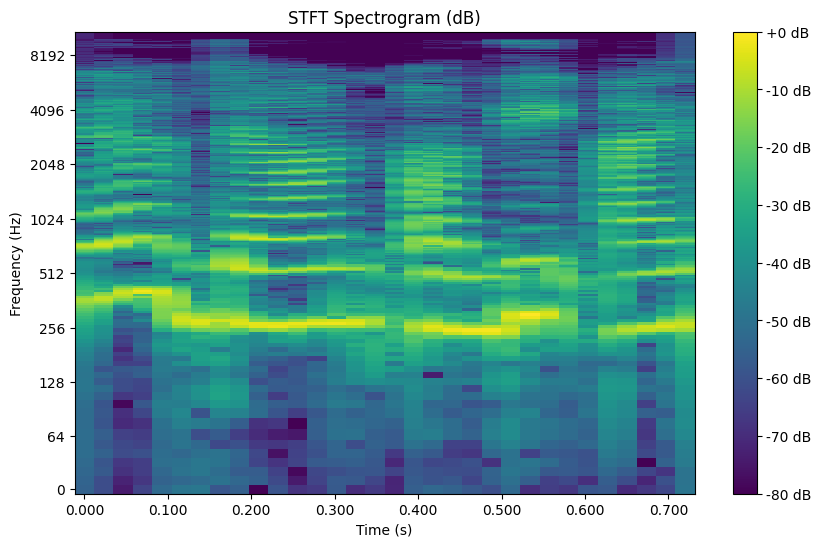

In [40]:
train_loader, val_loader, test_loader = create_dataloaders(path, batch_size=BATCH_SIZE)

sample_spec = get_sample(train_loader)
print_sample_spec(sample_spec)
print_sample_spec(get_sample(train_loader))

In [45]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_loader.dataset):.4f}")

        # Validation
        model.eval()
        val_loss, correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
        
        print(f"Validation Loss: {val_loss / len(val_loader.dataset):.4f}, Accuracy: {correct / len(val_loader.dataset):.4f}")

model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters())

train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)


RuntimeError: Given groups=1, weight of size [32, 3, 2, 2], expected input[1, 32, 1025, 32] to have 3 channels, but got 32 channels instead